# Progressive Hierarchical Fusion

Overview
1. Fuse images hierarchically
The images were fused hierarchically, having the original images in level 0. Every two images fuse to make one image in the next progressive level. 
i.e. images 0 and 1 from level 0 fuse to make image 0 from level 1; images 2 and 3 fuse to make image 1 in level 1; images 0 and 1 make image 0 in level 2; this continues until there is only one fully fused image.

2. The images are sorted under ../FusedDataset/FusedImages_Level_#/imgs.tif

3. Implement denoising model
This denoising model should learn the pattern of the noise throughout the fusions. This pattern should be learned and then applied to the level 0 images for a denoised output. 
The features from level 0 underneath the noise while the highest level should represent how a denoised image should look like, however, the features are blurred and so this should be considered. 

## Loading and Preparing the data

In [1]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import os
import torchvision.transforms as transforms

class FusionImageDataset(Dataset):
    def __init__(self, base_indices, transform=None):
        self.transform = transform if transform else transforms.ToTensor()
        self.image_groups = []
        
        for base_idx in base_indices:
            paths = []
            names = []
            current_idx = base_idx
            
            # Level 0
            name = f"Fused_Image_Level_0_{base_idx}.tif"
            path = f"../FusedDataset/FusedImages_Level_0/{name}"
            paths.append(path)
            names.append(name)
            
            # Levels 1-7
            for level in range(1, 8):
                current_idx = current_idx // 2
                name = f"Fused_Image_Level_{level}_{current_idx}.tif"
                path = f"../FusedDataset/FusedImages_Level_{level}/{name}"
                paths.append(path)
                names.append(name)
                
            self.image_groups.append((paths, names))
    
    def __len__(self):
        return len(self.image_groups)
    
    def __getitem__(self, idx):
        paths, names = self.image_groups[idx]
        images = []
        
        for path in paths:
            img = Image.open(path)
            img = self.transform(img)
            images.append(img)
            
        return torch.stack(images), names

dataset = FusionImageDataset(base_indices=[0, 1, 2, 68])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Example loading images and printing their properties
for images, names in dataloader:
    print("\nLoaded image group:")
    for i, (img, name) in enumerate(zip(images[0], names)):  # images[0] to remove batch dimension
        print(f"Level {i}: {name}")
        print(f"Image shape: {img.shape}, Value range: [{img.min():.2f}, {img.max():.2f}]")

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Loaded image group:
Level 0: ('Fused_Image_Level_0_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.22, 0.95]
Level 1: ('Fused_Image_Level_1_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.27, 0.95]
Level 2: ('Fused_Image_Level_2_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.30, 0.94]
Level 3: ('Fused_Image_Level_3_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.33, 0.84]
Level 4: ('Fused_Image_Level_4_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.34, 0.84]
Level 5: ('Fused_Image_Level_5_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.35, 0.88]
Level 6: ('Fused_Image_Level_6_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.35, 0.84]
Level 7: ('Fused_Image_Level_7_0.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.31, 0.86]

Loaded image group:
Level 0: ('Fused_Image_Level_0_1.tif',)
Image shape: torch.Size([1, 512, 512]), Value range: [0.21, 0.96]
Leve

In [2]:
sample = next(iter(dataloader))
type(sample)

list

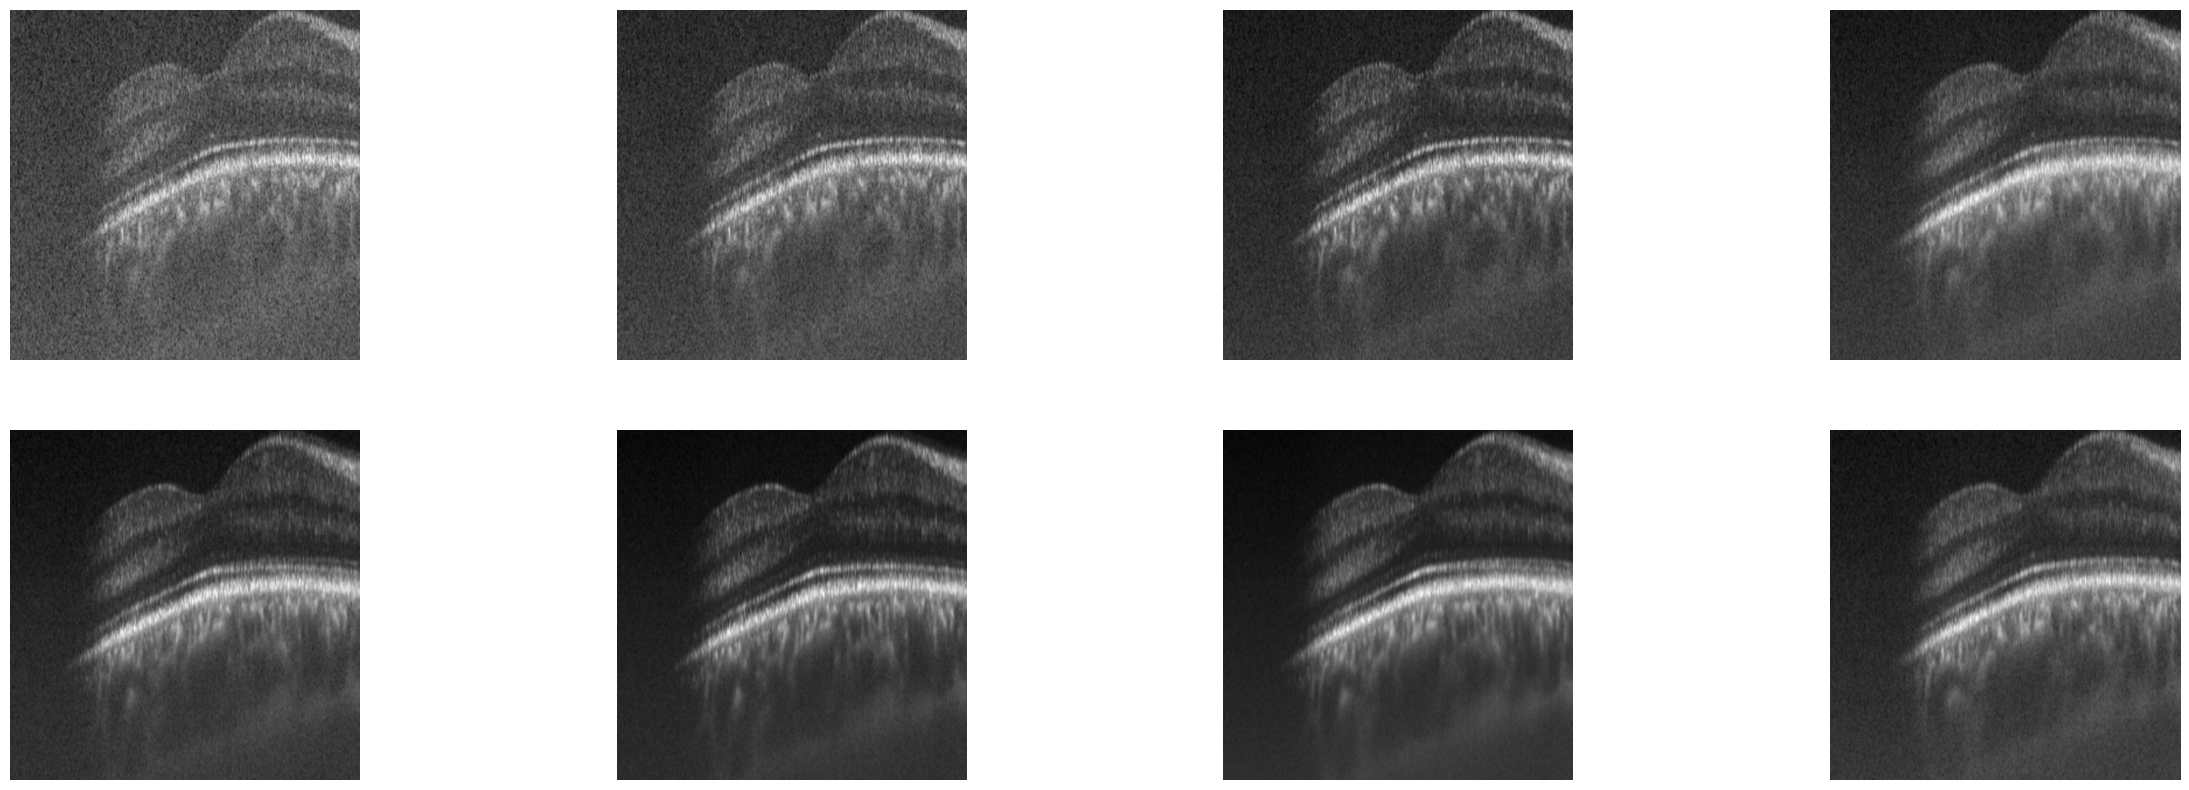

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

imgbatch = sample[0][0]

# import figure
plt.figure(figsize=(30, 10))

num_images = len(imgbatch)
cols, rows = 4, 2

for i, img in enumerate(imgbatch):
    img = img.permute(1, 2, 0)

    img = img.numpy()

    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()


## Feature Preservation

I have a bunch of OCT images (level 0). I fused every two to make a new one (level 1). I repeated this until I have only 1 fused image left.
My current dataloader is basically for a given image looks like this:
[('Fused_Image_Level_0_0.tif',),
 ('Fused_Image_Level_1_0.tif',),
 ('Fused_Image_Level_2_0.tif',),
 ('Fused_Image_Level_3_0.tif',),
 ('Fused_Image_Level_4_0.tif',),
 ('Fused_Image_Level_5_0.tif',),
 ('Fused_Image_Level_6_0.tif',),
 ('Fused_Image_Level_7_0.tif',)]

That is, if it directly contributes to the fused image
[('Fused_Image_Level_0_0.tif',), ('Fused_Image_Level_1_0.tif',), ('Fused_Image_Level_2_0.tif',), ('Fused_Image_Level_3_0.tif',), ('Fused_Image_Level_4_0.tif',), ('Fused_Image_Level_5_0.tif',), ('Fused_Image_Level_6_0.tif',), ('Fused_Image_Level_7_0.tif',)]
[('Fused_Image_Level_0_1.tif',), ('Fused_Image_Level_1_0.tif',), ('Fused_Image_Level_2_0.tif',), ('Fused_Image_Level_3_0.tif',), ('Fused_Image_Level_4_0.tif',), ('Fused_Image_Level_5_0.tif',), ('Fused_Image_Level_6_0.tif',), ('Fused_Image_Level_7_0.tif',)]
[('Fused_Image_Level_0_2.tif',), ('Fused_Image_Level_1_1.tif',), ('Fused_Image_Level_2_0.tif',), ('Fused_Image_Level_3_0.tif',), ('Fused_Image_Level_4_0.tif',), ('Fused_Image_Level_5_0.tif',), ('Fused_Image_Level_6_0.tif',), ('Fused_Image_Level_7_0.tif',)]
[('Fused_Image_Level_0_68.tif',), ('Fused_Image_Level_1_34.tif',), ('Fused_Image_Level_2_17.tif',), ('Fused_Image_Level_3_8.tif',), ('Fused_Image_Level_4_4.tif',), ('Fused_Image_Level_5_2.tif',), ('Fused_Image_Level_6_1.tif',), ('Fused_Image_Level_7_0.tif',)]

In my code I have stopped at level 6 because the 7th may be the most denoised but the subtle features blend too much

With any 1 sample from the data loader, I want to start at level 6 to identify the broad features, then use this to track the faded/subtle features that are lost during the fusion process at the 0th level

I have a couple ideas:
1. Take level 6 image, identify the features then plaster that onto the level 0 image which then is analysed and the areas within this are identified as the broad areas of interest. The contrast and pattern is analysed and the structure/saturation is recognised as features, then the subtle features within/near the level 6 roi can be recognised then more concrete shapes can take place for the level 0 feature extraction. For example, if there is a clear subtle triangle in the noise, but the 6th image due to the fusion looks like a circle, I would want that circle to be the initial roi but then when its put ontop of the triangle there is clear contrast different between the parts which are and are not the triangle, the triangle is then picked up as the feature which is highlighted.

2. The other way is to do step 1 except iteratively, applying it to level 5 then 4 and so on. Iteratively getting closer and closer to the original shape. But this may be too complicated for the time being.

In [18]:
sample = next(iter(dataloader))
print(type(sample))
print(sample[0].shape)

<class 'list'>
torch.Size([1, 8, 1, 512, 512])


In [28]:
for sample in dataloader:
    print(sample[1])

[('Fused_Image_Level_0_0.tif',), ('Fused_Image_Level_1_0.tif',), ('Fused_Image_Level_2_0.tif',), ('Fused_Image_Level_3_0.tif',), ('Fused_Image_Level_4_0.tif',), ('Fused_Image_Level_5_0.tif',), ('Fused_Image_Level_6_0.tif',), ('Fused_Image_Level_7_0.tif',)]
[('Fused_Image_Level_0_1.tif',), ('Fused_Image_Level_1_0.tif',), ('Fused_Image_Level_2_0.tif',), ('Fused_Image_Level_3_0.tif',), ('Fused_Image_Level_4_0.tif',), ('Fused_Image_Level_5_0.tif',), ('Fused_Image_Level_6_0.tif',), ('Fused_Image_Level_7_0.tif',)]
[('Fused_Image_Level_0_2.tif',), ('Fused_Image_Level_1_1.tif',), ('Fused_Image_Level_2_0.tif',), ('Fused_Image_Level_3_0.tif',), ('Fused_Image_Level_4_0.tif',), ('Fused_Image_Level_5_0.tif',), ('Fused_Image_Level_6_0.tif',), ('Fused_Image_Level_7_0.tif',)]
[('Fused_Image_Level_0_68.tif',), ('Fused_Image_Level_1_34.tif',), ('Fused_Image_Level_2_17.tif',), ('Fused_Image_Level_3_8.tif',), ('Fused_Image_Level_4_4.tif',), ('Fused_Image_Level_5_2.tif',), ('Fused_Image_Level_6_1.tif',), (

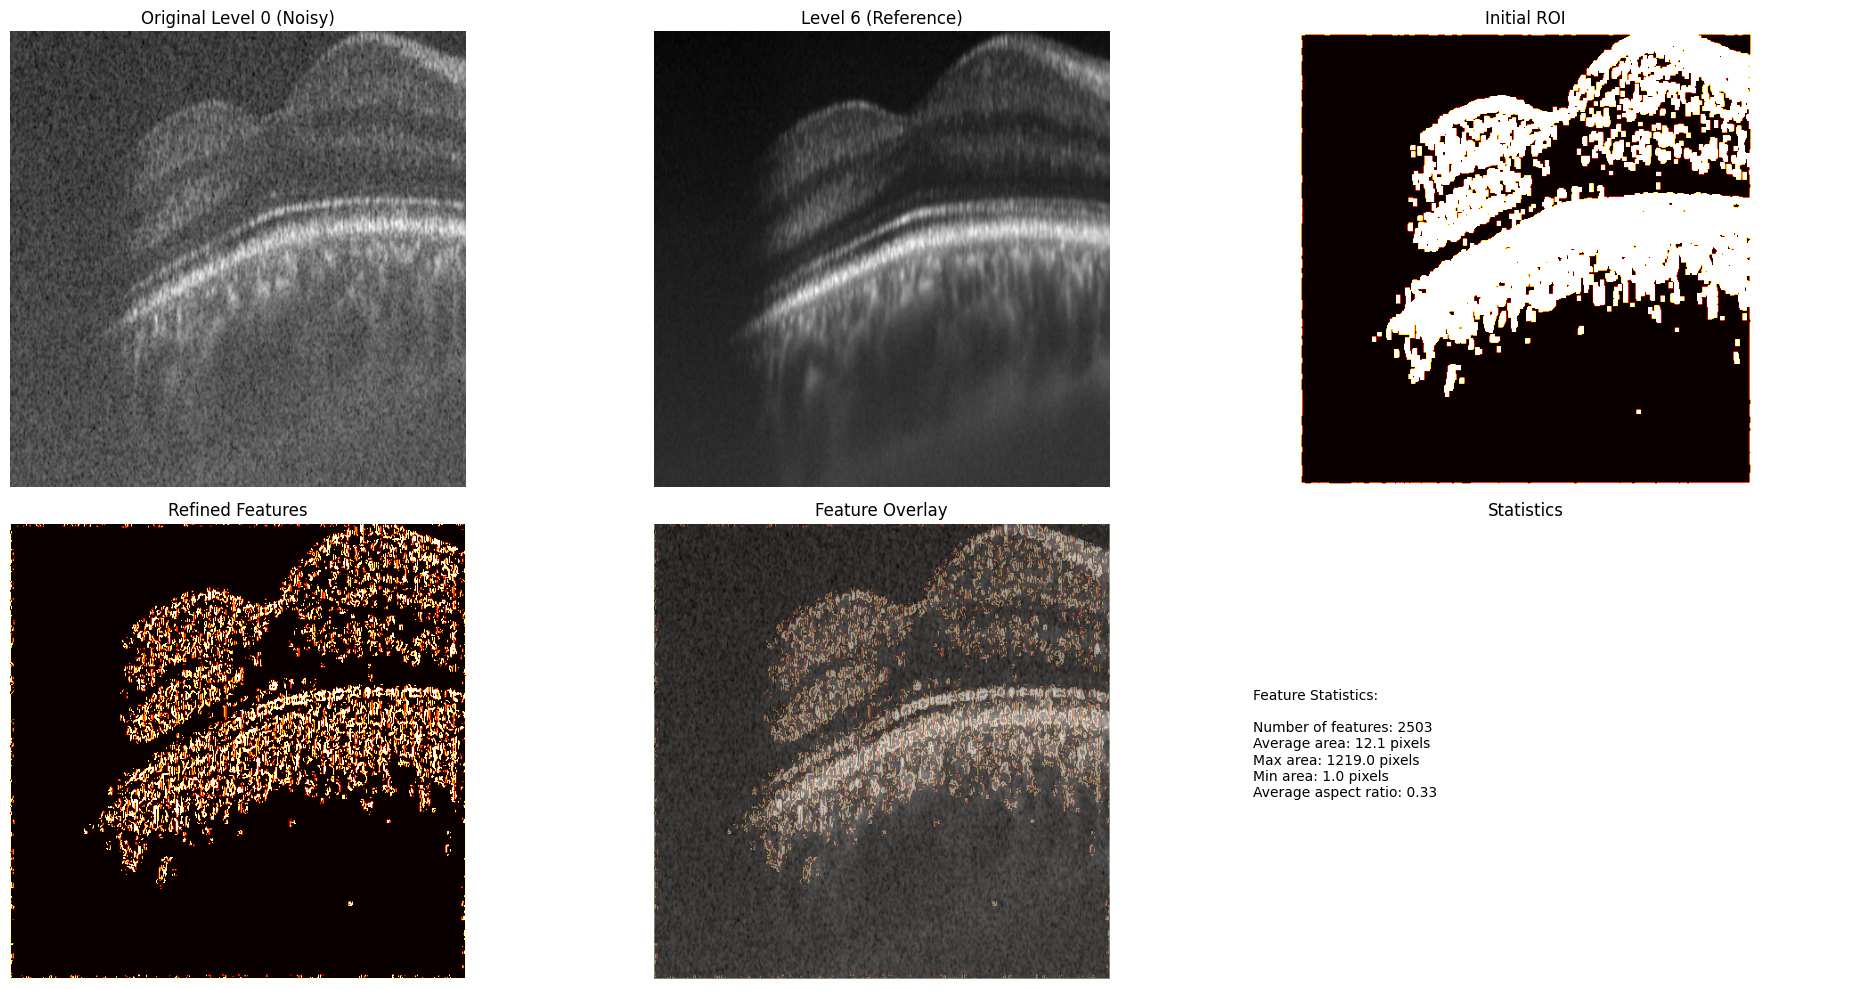

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, label, center_of_mass


class EnhancedFeatureProcessor:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        # Initialize Sobel operators
        self.sobel_x = torch.tensor([[-1, 0, 1], 
                                   [-2, 0, 2], 
                                   [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.sobel_y = torch.tensor([[-1, -2, -1], 
                                   [0, 0, 0], 
                                   [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.sobel_x = self.sobel_x.to(device)
        self.sobel_y = self.sobel_y.to(device)
        
        # Initialize Gaussian kernels
        self.gaussian_kernels = self._create_gaussian_kernels()

    def _create_gaussian_kernels(self):
        sizes = [3, 5, 7]
        kernels = []
        for size in sizes:
            kernel = self._create_gaussian_kernel(size, sigma=size/6.0)
            kernel = torch.from_numpy(kernel).float().unsqueeze(0).unsqueeze(0).to(self.device)
            kernels.append(kernel)
        return kernels

    def _create_gaussian_kernel(self, size, sigma):
        x = np.linspace(-(size-1)/2, (size-1)/2, size)
        gauss = np.exp(-0.5 * np.square(x) / np.square(sigma))
        kernel = np.outer(gauss, gauss)
        return kernel / kernel.sum()

    def denoise_image(self, image, strength=0.5):
        """Apply multi-scale denoising"""
        denoised = image
        for kernel in self.gaussian_kernels:
            filtered = F.conv2d(denoised, kernel, padding=kernel.shape[-1]//2)
            denoised = strength * filtered + (1 - strength) * denoised
        return denoised

    def extract_robust_edges(self, image, noise_threshold=0.1):
        """Extract edges with noise resistance"""
        # Apply Sobel operators
        grad_x = F.conv2d(image, self.sobel_x, padding=1)
        grad_y = F.conv2d(image, self.sobel_y, padding=1)
        
        # Calculate gradient magnitude
        edge_map = torch.sqrt(grad_x**2 + grad_y**2)
        edge_map = F.relu(edge_map - noise_threshold)
        
        return edge_map

    def process_sample(self, sample):
        """Process a single sample from the DataLoader"""
        images = sample[0].to(self.device)  # Shape: [1, 8, 1, 512, 512]
        names = sample[1] if len(sample) > 1 else None
        
        results = {
            'denoised': [],
            'edges': [],
            'features': [],
            'consistency': []
        }
        
        # Process each level
        for level in range(images.size(1)):
            # Extract single level image: [1, 1, 512, 512]
            level_image = images[:, level]
            
            # Denoise
            denoised = self.denoise_image(level_image, strength=0.3)
            results['denoised'].append(denoised)
            
            # Extract edges
            edges = self.extract_robust_edges(denoised, noise_threshold=0.05)
            results['edges'].append(edges)
            
            # Create feature mask
            features = (edges > edges.mean()).float()
            results['features'].append(features)
        
        # Calculate consistency between levels
        for i in range(len(results['edges']) - 1):
            consistency = F.cosine_similarity(
                results['edges'][i].view(1, -1),
                results['edges'][i+1].view(1, -1)
            )
            results['consistency'].append(consistency)
        
        return results

    def visualize_results(self, sample, results, save_path=None):
        """Visualize the processing results"""
        images = sample[0]
        num_levels = images.size(1)
        
        # Create figure with subplots
        fig, axes = plt.subplots(3, num_levels, figsize=(20, 16))
        
        # Original Images
        for i in range(num_levels):
            axes[0, i].imshow(images[0, i, 0].cpu(), cmap='gray')
            axes[0, i].axis('off')
        
        # Edge Maps
        for i in range(num_levels):
            axes[1, i].imshow(results['edges'][i][0, 0].cpu(), cmap='hot')
            axes[1, i].set_title(f'Edges Level {i}')
            axes[1, i].axis('off')
        
        # Feature Masks
        for i in range(num_levels):
            axes[2, i].imshow(results['features'][i][0, 0].cpu(), cmap='binary')
            axes[2, i].set_title(f'Features Level {i}')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()
        
        # Plot consistency scores
        if results['consistency']:
            plt.figure(figsize=(10, 5))
            plt.plot([c.item() for c in results['consistency']], marker='o')
            plt.title('Feature Consistency Between Consecutive Levels')
            plt.xlabel('Level Transition')
            plt.ylabel('Consistency Score')
            plt.grid(True)
            plt.show()

class FeatureTracker(EnhancedFeatureProcessor):
    def __init__(self, 
                 device='cuda' if torch.cuda.is_available() else 'cpu',
                 local_kernel_size=15,  # Size of local normalization window
                 gradient_threshold_factor=0.3,  # Factor for gradient threshold
                 local_window_stride=1):  # How densely to sample local windows
        super().__init__(device)
        self.reference_level = 6
        self.target_level = 0
        self.local_kernel_size = local_kernel_size
        self.gradient_threshold_factor = gradient_threshold_factor
        self.local_window_stride = local_window_stride

    def _create_structural_element(self, size=3):
        """Create a structural element for dilation"""
        return np.ones((size, size))

    def identify_reference_features(self, features, threshold=0.5):
        """First stage: Extract obvious features from the reference level"""
        # Convert to numpy for morphological operations
        features_np = features.cpu().numpy()[0, 0]
        
        # Initial mask for obvious features
        feature_mask = features_np > threshold
        
        # Dilate features slightly to create search regions
        dilated_features = binary_dilation(feature_mask, 
                                        structure=self._create_structural_element(5))
        
        return torch.from_numpy(dilated_features).float().to(self.device)
    
    def refine_features(self, noisy_image: torch.Tensor, initial_mask: torch.Tensor) -> torch.Tensor:
            """Modified to use class parameters for feature detection"""
            # Handle dimensions
            if len(noisy_image.shape) == 2:
                noisy_image = noisy_image.unsqueeze(0).unsqueeze(0)
            elif len(noisy_image.shape) == 3:
                noisy_image = noisy_image.unsqueeze(0)
                
            if len(initial_mask.shape) == 2:
                initial_mask = initial_mask.unsqueeze(0).unsqueeze(0)
            elif len(initial_mask.shape) == 3:
                initial_mask = initial_mask.unsqueeze(0)

            noisy_image = noisy_image.to(self.device)
            
            # Calculate gradients
            grad_x = F.conv2d(noisy_image, self.sobel_x, padding=1)
            grad_y = F.conv2d(noisy_image, self.sobel_y, padding=1)
            gradient_mag = torch.sqrt(grad_x**2 + grad_y**2)
            
            # Local normalization with adjustable kernel size
            padding = self.local_kernel_size // 2
            avg_kernel = torch.ones(1, 1, self.local_kernel_size, self.local_kernel_size).to(self.device)
            avg_kernel = avg_kernel / avg_kernel.sum()
            
            # Calculate local statistics with stride
            local_mean = F.conv2d(gradient_mag, avg_kernel, padding=padding, stride=self.local_window_stride)
            local_var = F.conv2d(gradient_mag**2, avg_kernel, padding=padding, stride=self.local_window_stride) 
            local_var = local_var - local_mean**2
            local_std = torch.sqrt(torch.clamp(local_var, min=1e-6))
            
            # Normalize locally
            normalized_gradients = (gradient_mag - local_mean) / (local_std + 1e-6)
            
            # Get features within ROI
            roi_gradients = normalized_gradients * initial_mask
            valid_gradients = roi_gradients[initial_mask > 0]
            
            if len(valid_gradients) > 0:
                mean_gradient = valid_gradients.mean()
                std_gradient = valid_gradients.std()
                
                # Use adjustable threshold factor
                gradient_threshold = mean_gradient + self.gradient_threshold_factor * std_gradient
                refined_mask = (roi_gradients > gradient_threshold).float()
            else:
                refined_mask = initial_mask
            
            return refined_mask
    
    def identify_contrast_levels(self, reference_image: torch.Tensor, num_levels=4):
        """Identify different contrast levels in the reference image"""
        # Ensure proper dimensions
        if len(reference_image.shape) == 2:
            reference_image = reference_image.unsqueeze(0).unsqueeze(0)
        elif len(reference_image.shape) == 3:
            reference_image = reference_image.unsqueeze(0)
        
        # Get intensity values
        intensities = reference_image.cpu().numpy()[0, 0]
        
        # Calculate histogram
        hist, bins = np.histogram(intensities, bins=num_levels)
        
        # Return bin edges as contrast levels
        return bins
    
    def refine_features_with_contrast(self, noisy_image: torch.Tensor, reference_image: torch.Tensor, initial_mask: torch.Tensor) -> torch.Tensor:
        """Enhanced feature refinement using contrast levels from reference"""
        # Handle dimensions and move to correct device
        if len(noisy_image.shape) == 2:
            noisy_image = noisy_image.unsqueeze(0).unsqueeze(0)
        elif len(noisy_image.shape) == 3:
            noisy_image = noisy_image.unsqueeze(0)
        
        # Move to device
        noisy_image = noisy_image.to(self.device)
        reference_image = reference_image.to(self.device)
        initial_mask = initial_mask.to(self.device)
            
        # Get contrast levels from reference
        contrast_levels = self.identify_contrast_levels(reference_image)
        
        # Initialize combined mask
        combined_mask = torch.zeros_like(noisy_image).to(self.device)
        
        # Detect features at each contrast level
        for i in range(len(contrast_levels)-1):
            lower = contrast_levels[i]
            upper = contrast_levels[i+1]
            
            # Adjust gradient sensitivity based on contrast level
            sensitivity = 1.0 - (i / (len(contrast_levels)-1))  
            gradient_threshold = self.gradient_threshold_factor * sensitivity
            
            # Calculate gradients
            grad_x = F.conv2d(noisy_image, self.sobel_x, padding=1)
            grad_y = F.conv2d(noisy_image, self.sobel_y, padding=1)
            gradient_mag = torch.sqrt(grad_x**2 + grad_y**2)
            
            # Local normalization
            padding = self.local_kernel_size // 2
            avg_kernel = torch.ones(1, 1, self.local_kernel_size, self.local_kernel_size).to(self.device)
            avg_kernel = avg_kernel / avg_kernel.sum()
            
            local_mean = F.conv2d(gradient_mag, avg_kernel, padding=padding)
            local_var = F.conv2d(gradient_mag**2, avg_kernel, padding=padding) - local_mean**2
            local_std = torch.sqrt(torch.clamp(local_var, min=1e-6))
            
            # Normalize locally with contrast-based sensitivity
            normalized_gradients = (gradient_mag - local_mean) / (local_std + 1e-6)
            
            # Get features within ROI and contrast level
            roi_gradients = normalized_gradients * initial_mask
            contrast_mask = ((noisy_image >= lower) & (noisy_image < upper)).float()
            level_gradients = roi_gradients * contrast_mask
            
            # Apply threshold with contrast-based sensitivity
            level_mask = (level_gradients > gradient_threshold).float()
            
            # Add to combined mask with contrast-based weighting
            combined_mask = combined_mask + level_mask * sensitivity

        # Normalize combined mask
        combined_mask = (combined_mask > 0).float()
        
        return combined_mask
        
    def track_features_to_noisy_level(self, sample, results):
        """Enhanced feature tracking with contrast-aware refinement"""
        # Get reference level features and ensure they're on the correct device
        ref_features = results['features'][self.reference_level]
        ref_image = sample[0][0, self.reference_level].to(self.device)
        initial_mask = self.identify_reference_features(ref_features)
        
        # Get noisy image and ensure it's on the correct device
        noisy_image = sample[0][0, self.target_level].clone().to(self.device)
        
        # Refine features using contrast information
        refined_features = self.refine_features_with_contrast(noisy_image, ref_image, initial_mask)
        
        # Create highlighted version
        highlighted = sample[0][0, self.target_level, 0].clone().to(self.device)
        
        # Analyze refined features
        feature_analysis = self.analyze_features(refined_features.squeeze())
        
        return {
            'initial_mask': initial_mask,
            'refined_features': refined_features,
            'highlighted': highlighted,
            'highlighted_features': refined_features,
            'feature_analysis': feature_analysis
        }

    def analyze_features(self, mask):
        """Analyze the detected features and extract properties"""
        # Convert mask to numpy for analysis
        mask_np = mask.cpu().numpy()
        
        # Label connected components
        labeled_features, num_features = label(mask_np)
        
        # Initialize lists to store feature properties
        features_props = []
        
        for i in range(1, num_features + 1):
            # Create mask for current feature
            feature_mask = labeled_features == i
            
            # Calculate properties
            area = np.sum(feature_mask)
            cy, cx = center_of_mass(feature_mask)
            
            # Get bounding box
            rows, cols = np.nonzero(feature_mask)
            if len(rows) > 0 and len(cols) > 0:
                bbox = [np.min(rows), np.min(cols), np.max(rows), np.max(cols)]
            else:
                continue
                
            # Calculate aspect ratio
            height = bbox[2] - bbox[0]
            width = bbox[3] - bbox[1]
            aspect_ratio = width / height if height > 0 else 0
            
            features_props.append({
                'id': i,
                'center': (cx, cy),
                'area': area,
                'bbox': bbox,
                'aspect_ratio': aspect_ratio
            })
            
        return features_props
    
    def visualize_tracking_results(self, sample, results, tracking_results):
        """Enhanced visualization without feature analysis overlay"""
        plt.figure(figsize=(20, 10))
        
        # Original noisy image
        plt.subplot(231)
        plt.imshow(sample[0][0, self.target_level, 0].cpu(), cmap='gray')
        plt.title(f'Original Level {self.target_level} (Noisy)')
        plt.axis('off')
        
        # Reference level image
        plt.subplot(232)
        plt.imshow(sample[0][0, self.reference_level, 0].cpu(), cmap='gray')
        plt.title(f'Level {self.reference_level} (Reference)')
        plt.axis('off')
        
        # Initial ROI mask
        plt.subplot(233)
        plt.imshow(tracking_results['initial_mask'].cpu().squeeze(), cmap='hot')
        plt.title('Initial ROI')
        plt.axis('off')
        
        # Refined features
        plt.subplot(234)
        plt.imshow(tracking_results['refined_features'].cpu().squeeze(), cmap='hot')
        plt.title('Refined Features')
        plt.axis('off')
        
        # Simple overlay without annotations
        plt.subplot(235)
        combined = sample[0][0, self.target_level, 0].cpu()
        refined = tracking_results['refined_features'].cpu().squeeze()
        plt.imshow(combined, cmap='gray')
        plt.imshow(refined, cmap='hot', alpha=0.3)
        plt.title('Feature Overlay')
        plt.axis('off')
        
        # Feature statistics
        plt.subplot(236)
        stats_text = "Feature Statistics:\n\n"
        areas = [f['area'] for f in tracking_results['feature_analysis']]
        ratios = [f['aspect_ratio'] for f in tracking_results['feature_analysis']]
        
        if areas:
            stats_text += f"Number of features: {len(tracking_results['feature_analysis'])}\n"
            stats_text += f"Average area: {np.mean(areas):.1f} pixels\n"
            stats_text += f"Max area: {np.max(areas):.1f} pixels\n"
            stats_text += f"Min area: {np.min(areas):.1f} pixels\n"
            stats_text += f"Average aspect ratio: {np.mean(ratios):.2f}\n"
        else:
            stats_text += "No features detected"
        
        plt.text(0.1, 0.5, stats_text, fontsize=10, va='center')
        plt.axis('off')
        plt.title('Statistics')
        
        plt.tight_layout()
        plt.show()

    def print_feature_report(self, tracking_results):
        """Print a detailed report of the detected features"""
        print("\nFeature Analysis Report")
        print("=" * 50)
        
        features = tracking_results['feature_analysis']
        print(f"\nTotal features detected: {len(features)}")
        
        print("\nFeature Details:")
        print("-" * 30)
        for feat in features:
            print(f"\nFeature {feat['id']}:")
            print(f"  Center: ({feat['center'][0]:.1f}, {feat['center'][1]:.1f})")
            print(f"  Area: {feat['area']} pixels")
            print(f"  Aspect Ratio: {feat['aspect_ratio']:.2f}")
            print(f"  Bounding Box: {feat['bbox']}")

# Try different settings
tracker = FeatureTracker(
    local_kernel_size=21,
    gradient_threshold_factor=0.3,
    local_window_stride=1
)

# Process sample and visualize
sample = next(iter(dataloader))
results = tracker.process_sample(sample)
tracking_results = tracker.track_features_to_noisy_level(sample, results)
tracker.visualize_tracking_results(sample, results, tracking_results)

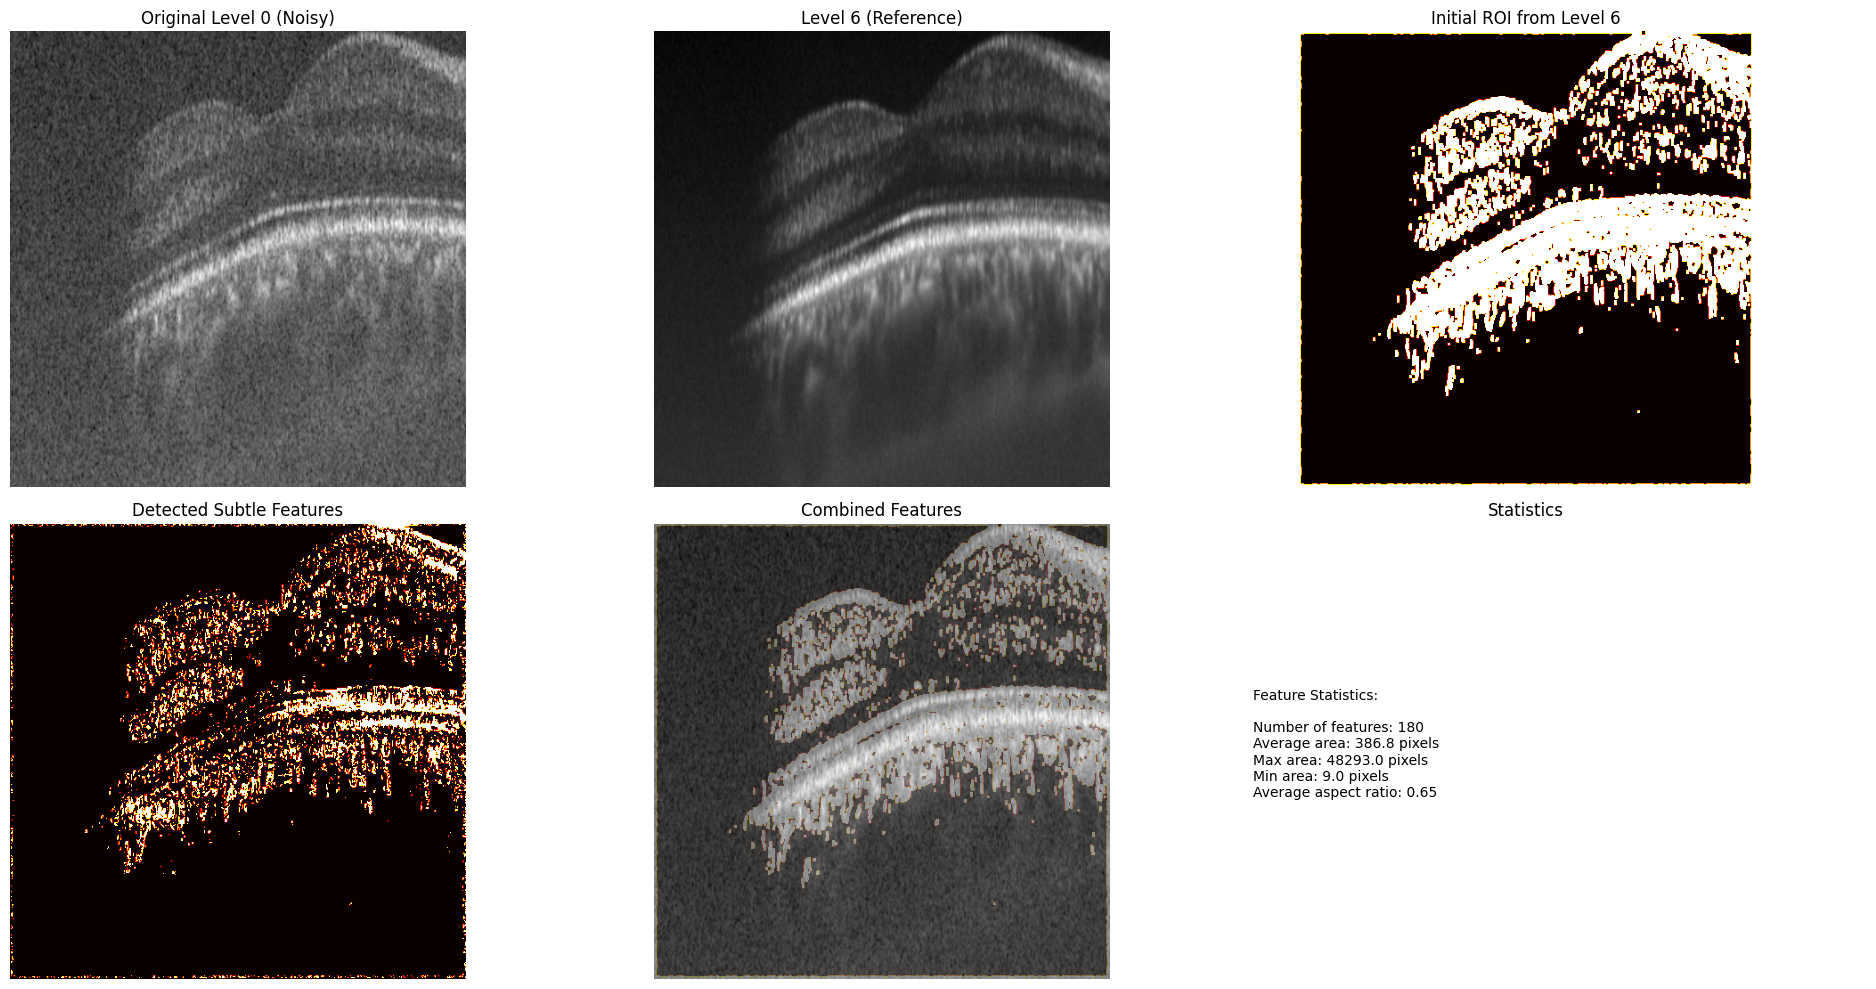

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, label, center_of_mass
# import Dict
from typing import Dict


class EnhancedFeatureProcessor:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        # Initialize Sobel operators
        self.sobel_x = torch.tensor([[-1, 0, 1], 
                                   [-2, 0, 2], 
                                   [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.sobel_y = torch.tensor([[-1, -2, -1], 
                                   [0, 0, 0], 
                                   [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.sobel_x = self.sobel_x.to(device)
        self.sobel_y = self.sobel_y.to(device)
        
        # Initialize Gaussian kernels
        self.gaussian_kernels = self._create_gaussian_kernels()

    def _create_gaussian_kernels(self):
        sizes = [3, 5, 7]
        kernels = []
        for size in sizes:
            kernel = self._create_gaussian_kernel(size, sigma=size/6.0)
            kernel = torch.from_numpy(kernel).float().unsqueeze(0).unsqueeze(0).to(self.device)
            kernels.append(kernel)
        return kernels

    def _create_gaussian_kernel(self, size, sigma):
        x = np.linspace(-(size-1)/2, (size-1)/2, size)
        gauss = np.exp(-0.5 * np.square(x) / np.square(sigma))
        kernel = np.outer(gauss, gauss)
        return kernel / kernel.sum()

    def denoise_image(self, image, strength=0.5):
        """Apply multi-scale denoising"""
        denoised = image
        for kernel in self.gaussian_kernels:
            filtered = F.conv2d(denoised, kernel, padding=kernel.shape[-1]//2)
            denoised = strength * filtered + (1 - strength) * denoised
        return denoised

    def extract_robust_edges(self, image, noise_threshold=0.1):
        """Extract edges with noise resistance"""
        # Apply Sobel operators
        grad_x = F.conv2d(image, self.sobel_x, padding=1)
        grad_y = F.conv2d(image, self.sobel_y, padding=1)
        
        # Calculate gradient magnitude
        edge_map = torch.sqrt(grad_x**2 + grad_y**2)
        edge_map = F.relu(edge_map - noise_threshold)
        
        return edge_map

    def process_sample(self, sample):
        """Process a single sample from the DataLoader"""
        images = sample[0].to(self.device)  # Shape: [1, 8, 1, 512, 512]
        names = sample[1] if len(sample) > 1 else None
        
        results = {
            'denoised': [],
            'edges': [],
            'features': [],
            'consistency': []
        }
        
        # Process each level
        for level in range(images.size(1)):
            # Extract single level image: [1, 1, 512, 512]
            level_image = images[:, level]
            
            # Denoise
            denoised = self.denoise_image(level_image, strength=0.3)
            results['denoised'].append(denoised)
            
            # Extract edges
            edges = self.extract_robust_edges(denoised, noise_threshold=0.05)
            results['edges'].append(edges)
            
            # Create feature mask
            features = (edges > edges.mean()).float()
            results['features'].append(features)
        
        # Calculate consistency between levels
        for i in range(len(results['edges']) - 1):
            consistency = F.cosine_similarity(
                results['edges'][i].view(1, -1),
                results['edges'][i+1].view(1, -1)
            )
            results['consistency'].append(consistency)
        
        return results

    def visualize_results(self, sample, results, save_path=None):
        """Visualize the processing results"""
        images = sample[0]
        num_levels = images.size(1)
        
        # Create figure with subplots
        fig, axes = plt.subplots(3, num_levels, figsize=(20, 16))
        
        # Original Images
        for i in range(num_levels):
            axes[0, i].imshow(images[0, i, 0].cpu(), cmap='gray')
            axes[0, i].axis('off')
        
        # Edge Maps
        for i in range(num_levels):
            axes[1, i].imshow(results['edges'][i][0, 0].cpu(), cmap='hot')
            axes[1, i].set_title(f'Edges Level {i}')
            axes[1, i].axis('off')
        
        # Feature Masks
        for i in range(num_levels):
            axes[2, i].imshow(results['features'][i][0, 0].cpu(), cmap='binary')
            axes[2, i].set_title(f'Features Level {i}')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()
        
        # Plot consistency scores
        if results['consistency']:
            plt.figure(figsize=(10, 5))
            plt.plot([c.item() for c in results['consistency']], marker='o')
            plt.title('Feature Consistency Between Consecutive Levels')
            plt.xlabel('Level Transition')
            plt.ylabel('Consistency Score')
            plt.grid(True)
            plt.show()

class FeatureTracker(EnhancedFeatureProcessor):
    def __init__(self, 
                 device='cuda' if torch.cuda.is_available() else 'cpu',
                 local_kernel_size=15,  # Size of local normalization window
                 gradient_threshold_factor=0.3,  # Factor for gradient threshold
                 local_window_stride=1):  # How densely to sample local windows
        super().__init__(device)
        self.reference_level = 6
        self.target_level = 0
        self.local_kernel_size = local_kernel_size
        self.gradient_threshold_factor = gradient_threshold_factor
        self.local_window_stride = local_window_stride

    def _create_structural_element(self, size=3):
        """Create a structural element for dilation"""
        return np.ones((size, size))

    def identify_reference_features(self, features, min_threshold=0.15):  # Lowered threshold
        """Enhanced reference feature detection with increased sensitivity"""
        # Convert to numpy for operations
        features_np = features.cpu().numpy()[0, 0]
        
        # Calculate local statistics at multiple sensitivity levels
        from scipy.ndimage import uniform_filter
        kernel_size = 15  # Larger kernel for better local context
        
        # Get local statistics
        local_mean = uniform_filter(features_np, size=kernel_size)
        local_std = uniform_filter((features_np - local_mean)**2, size=kernel_size)**0.5
        
        # Create masks at different sensitivity levels
        high_sensitivity = features_np > (local_mean + 0.1 * local_std)  # Very sensitive
        med_sensitivity = features_np > (local_mean + 0.2 * local_std)   # Medium sensitivity
        
        # Combine masks with priority to more sensitive detection
        combined_mask = np.logical_or(high_sensitivity, med_sensitivity)
        
        # Light cleanup without losing subtle features
        from scipy.ndimage import binary_dilation
        final_roi = binary_dilation(combined_mask, 
                                structure=self._create_structural_element(3))  # Smaller dilation
        
        return torch.from_numpy(final_roi).float().to(self.device)
    
    def refine_features(self, noisy_image: torch.Tensor, initial_mask: torch.Tensor) -> torch.Tensor:
            """Modified to use class parameters for feature detection"""
            # Handle dimensions
            if len(noisy_image.shape) == 2:
                noisy_image = noisy_image.unsqueeze(0).unsqueeze(0)
            elif len(noisy_image.shape) == 3:
                noisy_image = noisy_image.unsqueeze(0)
                
            if len(initial_mask.shape) == 2:
                initial_mask = initial_mask.unsqueeze(0).unsqueeze(0)
            elif len(initial_mask.shape) == 3:
                initial_mask = initial_mask.unsqueeze(0)

            noisy_image = noisy_image.to(self.device)
            
            # Calculate gradients
            grad_x = F.conv2d(noisy_image, self.sobel_x, padding=1)
            grad_y = F.conv2d(noisy_image, self.sobel_y, padding=1)
            gradient_mag = torch.sqrt(grad_x**2 + grad_y**2)
            
            # Local normalization with adjustable kernel size
            padding = self.local_kernel_size // 2
            avg_kernel = torch.ones(1, 1, self.local_kernel_size, self.local_kernel_size).to(self.device)
            avg_kernel = avg_kernel / avg_kernel.sum()
            
            # Calculate local statistics with stride
            local_mean = F.conv2d(gradient_mag, avg_kernel, padding=padding, stride=self.local_window_stride)
            local_var = F.conv2d(gradient_mag**2, avg_kernel, padding=padding, stride=self.local_window_stride) 
            local_var = local_var - local_mean**2
            local_std = torch.sqrt(torch.clamp(local_var, min=1e-6))
            
            # Normalize locally
            normalized_gradients = (gradient_mag - local_mean) / (local_std + 1e-6)
            
            # Get features within ROI
            roi_gradients = normalized_gradients * initial_mask
            valid_gradients = roi_gradients[initial_mask > 0]
            
            if len(valid_gradients) > 0:
                mean_gradient = valid_gradients.mean()
                std_gradient = valid_gradients.std()
                
                # Use adjustable threshold factor
                gradient_threshold = mean_gradient + self.gradient_threshold_factor * std_gradient
                refined_mask = (roi_gradients > gradient_threshold).float()
            else:
                refined_mask = initial_mask
            
            return refined_mask
    
    def identify_contrast_levels(self, reference_image: torch.Tensor, num_levels=4):
        """Identify different contrast levels in the reference image"""
        # Ensure proper dimensions
        if len(reference_image.shape) == 2:
            reference_image = reference_image.unsqueeze(0).unsqueeze(0)
        elif len(reference_image.shape) == 3:
            reference_image = reference_image.unsqueeze(0)
        
        # Get intensity values
        intensities = reference_image.cpu().numpy()[0, 0]
        
        # Calculate histogram
        hist, bins = np.histogram(intensities, bins=num_levels)
        
        # Return bin edges as contrast levels
        return bins
    
    def refine_features_with_contrast(self, noisy_image: torch.Tensor, reference_image: torch.Tensor, initial_mask: torch.Tensor) -> torch.Tensor:
        """Enhanced feature refinement using contrast levels from reference"""
        # Handle dimensions and move to correct device
        if len(noisy_image.shape) == 2:
            noisy_image = noisy_image.unsqueeze(0).unsqueeze(0)
        elif len(noisy_image.shape) == 3:
            noisy_image = noisy_image.unsqueeze(0)
        
        # Move to device
        noisy_image = noisy_image.to(self.device)
        reference_image = reference_image.to(self.device)
        initial_mask = initial_mask.to(self.device)
            
        # Get contrast levels from reference
        contrast_levels = self.identify_contrast_levels(reference_image)
        
        # Initialize combined mask
        combined_mask = torch.zeros_like(noisy_image).to(self.device)
        
        # Detect features at each contrast level
        for i in range(len(contrast_levels)-1):
            lower = contrast_levels[i]
            upper = contrast_levels[i+1]
            
            # Adjust gradient sensitivity based on contrast level
            sensitivity = 1.0 - (i / (len(contrast_levels)-1))  
            gradient_threshold = self.gradient_threshold_factor * sensitivity
            
            # Calculate gradients
            grad_x = F.conv2d(noisy_image, self.sobel_x, padding=1)
            grad_y = F.conv2d(noisy_image, self.sobel_y, padding=1)
            gradient_mag = torch.sqrt(grad_x**2 + grad_y**2)
            
            # Local normalization
            padding = self.local_kernel_size // 2
            avg_kernel = torch.ones(1, 1, self.local_kernel_size, self.local_kernel_size).to(self.device)
            avg_kernel = avg_kernel / avg_kernel.sum()
            
            local_mean = F.conv2d(gradient_mag, avg_kernel, padding=padding)
            local_var = F.conv2d(gradient_mag**2, avg_kernel, padding=padding) - local_mean**2
            local_std = torch.sqrt(torch.clamp(local_var, min=1e-6))
            
            # Normalize locally with contrast-based sensitivity
            normalized_gradients = (gradient_mag - local_mean) / (local_std + 1e-6)
            
            # Get features within ROI and contrast level
            roi_gradients = normalized_gradients * initial_mask
            contrast_mask = ((noisy_image >= lower) & (noisy_image < upper)).float()
            level_gradients = roi_gradients * contrast_mask
            
            # Apply threshold with contrast-based sensitivity
            level_mask = (level_gradients > gradient_threshold).float()
            
            # Add to combined mask with contrast-based weighting
            combined_mask = combined_mask + level_mask * sensitivity

        # Normalize combined mask
        combined_mask = (combined_mask > 0).float()
        
        return combined_mask
        
    def track_features_to_noisy_level(self, sample, results):
        """Enhanced feature tracking with contrast-aware refinement"""
        # Get reference level features and ensure they're on the correct device
        ref_features = results['features'][self.reference_level]
        ref_image = sample[0][0, self.reference_level].to(self.device)
        initial_mask = self.identify_reference_features(ref_features)
        
        # Get noisy image and ensure it's on the correct device
        noisy_image = sample[0][0, self.target_level].clone().to(self.device)
        
        # Refine features using contrast information
        refined_features = self.refine_features_with_contrast(noisy_image, ref_image, initial_mask)
        
        # Create highlighted version
        highlighted = sample[0][0, self.target_level, 0].clone().to(self.device)
        
        # Analyze refined features
        feature_analysis = self.analyze_features(refined_features.squeeze())
        
        return {
            'initial_mask': initial_mask,
            'refined_features': refined_features,
            'highlighted': highlighted,
            'highlighted_features': refined_features,
            'feature_analysis': feature_analysis
        }

    def analyze_features(self, mask):
        """Analyze the detected features and extract properties"""
        # Convert mask to numpy for analysis
        mask_np = mask.cpu().numpy()
        
        # Label connected components
        labeled_features, num_features = label(mask_np)
        
        # Initialize lists to store feature properties
        features_props = []
        
        for i in range(1, num_features + 1):
            # Create mask for current feature
            feature_mask = labeled_features == i
            
            # Calculate properties
            area = np.sum(feature_mask)
            cy, cx = center_of_mass(feature_mask)
            
            # Get bounding box
            rows, cols = np.nonzero(feature_mask)
            if len(rows) > 0 and len(cols) > 0:
                bbox = [np.min(rows), np.min(cols), np.max(rows), np.max(cols)]
            else:
                continue
                
            # Calculate aspect ratio
            height = bbox[2] - bbox[0]
            width = bbox[3] - bbox[1]
            aspect_ratio = width / height if height > 0 else 0
            
            features_props.append({
                'id': i,
                'center': (cx, cy),
                'area': area,
                'bbox': bbox,
                'aspect_ratio': aspect_ratio
            })
            
        return features_props
    
    def analyze_structure_patterns(self, image: torch.Tensor, roi: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Analyze structural patterns within ROI"""
        # Ensure tensors are on correct device
        image = image.to(self.device)
        roi = roi.to(self.device)
        
        # Calculate local statistics within ROI
        kernel_size = self.local_kernel_size
        padding = kernel_size // 2
        avg_kernel = torch.ones(1, 1, kernel_size, kernel_size).to(self.device) / (kernel_size ** 2)
        
        # Get local contrast
        local_mean = F.conv2d(image, avg_kernel, padding=padding)
        local_var = F.conv2d(image**2, avg_kernel, padding=padding) - local_mean**2
        local_contrast = torch.sqrt(torch.clamp(local_var, min=1e-6))
        
        # Get directional patterns using Sobel
        grad_x = F.conv2d(image, self.sobel_x, padding=1)
        grad_y = F.conv2d(image, self.sobel_y, padding=1)
        
        # Calculate gradient direction and magnitude
        gradient_mag = torch.sqrt(grad_x**2 + grad_y**2)
        gradient_dir = torch.atan2(grad_y, grad_x)
        
        return {
            'local_contrast': local_contrast,
            'gradient_mag': gradient_mag,
            'gradient_dir': gradient_dir
        }

    def detect_subtle_features(self, 
                          noisy_image: torch.Tensor, 
                          reference_features: torch.Tensor,
                          roi: torch.Tensor) -> torch.Tensor:
        """Detect subtle features within ROI based on local patterns"""
        # Ensure proper dimensions for all tensors
        if len(noisy_image.shape) == 2:
            noisy_image = noisy_image.unsqueeze(0).unsqueeze(0)
        elif len(noisy_image.shape) == 3:
            noisy_image = noisy_image.unsqueeze(0)
            
        if len(reference_features.shape) == 2:
            reference_features = reference_features.unsqueeze(0).unsqueeze(0)
        elif len(reference_features.shape) == 3:
            reference_features = reference_features.unsqueeze(0)
            
        if len(roi.shape) == 2:
            roi = roi.unsqueeze(0).unsqueeze(0)
        elif len(roi.shape) == 3:
            roi = roi.unsqueeze(0)
        
        # Move all to device
        noisy_image = noisy_image.to(self.device)
        reference_features = reference_features.to(self.device)
        roi = roi.to(self.device)
        
        # Analyze patterns in both images
        noisy_patterns = self.analyze_structure_patterns(noisy_image, roi)
        ref_patterns = self.analyze_structure_patterns(reference_features, roi)
        
        # Look for structural differences within ROI
        contrast_diff = torch.abs(noisy_patterns['local_contrast'] - ref_patterns['local_contrast'])
        direction_diff = torch.abs(noisy_patterns['gradient_dir'] - ref_patterns['gradient_dir'])
        
        # Normalize differences
        contrast_diff = contrast_diff / (contrast_diff.max() + 1e-6)
        direction_diff = direction_diff / (direction_diff.max() + 1e-6)
        
        # Combine differences to identify areas of significant change
        pattern_diff = (contrast_diff + direction_diff) / 2
        
        # Apply adaptive thresholding within ROI
        roi_diff = pattern_diff * roi
        valid_diffs = roi_diff[roi > 0]
        
        if len(valid_diffs) > 0:
            mean_diff = valid_diffs.mean()
            std_diff = valid_diffs.std()
            threshold = mean_diff + self.gradient_threshold_factor * std_diff
            subtle_features = (roi_diff > threshold).float()
        else:
            subtle_features = roi.clone()
            
        return subtle_features

    def track_features_to_noisy_level(self, sample, results):
        """Enhanced feature tracking with subtle feature detection"""
        # Get level 6 reference features
        ref_features = results['features'][self.reference_level]
        ref_image = sample[0][0, self.reference_level].to(self.device)
        
        # Get initial ROI from level 6
        initial_mask = self.identify_reference_features(ref_features)
        
        # Get level 0 noisy image
        noisy_image = sample[0][0, self.target_level].clone().to(self.device)
        
        # Detect subtle features within ROI
        subtle_features = self.detect_subtle_features(noisy_image, ref_image, initial_mask)
        
        # Ensure dimensions match for combination
        if len(initial_mask.shape) != len(subtle_features.shape):
            initial_mask = initial_mask.unsqueeze(0).unsqueeze(0)
        
        # Combine initial ROI with subtle features
        combined_features = torch.max(initial_mask, subtle_features)
        
        # Analyze final features
        feature_analysis = self.analyze_features(combined_features.squeeze())
        
        return {
            'initial_mask': initial_mask,
            'subtle_features': subtle_features,
            'refined_features': combined_features,
            'highlighted': noisy_image,
            'feature_analysis': feature_analysis
        }

    def visualize_tracking_results(self, sample, results, tracking_results):
        """Enhanced visualization including subtle features"""
        plt.figure(figsize=(20, 10))
        
        # Original noisy image
        plt.subplot(231)
        plt.imshow(sample[0][0, self.target_level, 0].cpu(), cmap='gray')
        plt.title(f'Original Level 0 (Noisy)')
        plt.axis('off')
        
        # Reference level image
        plt.subplot(232)
        plt.imshow(sample[0][0, self.reference_level, 0].cpu(), cmap='gray')
        plt.title(f'Level 6 (Reference)')
        plt.axis('off')
        
        # Initial ROI mask
        plt.subplot(233)
        plt.imshow(tracking_results['initial_mask'].cpu().squeeze(), cmap='hot')
        plt.title('Initial ROI from Level 6')
        plt.axis('off')
        
        # Subtle features
        plt.subplot(234)
        plt.imshow(tracking_results['subtle_features'].cpu().squeeze(), cmap='hot')
        plt.title('Detected Subtle Features')
        plt.axis('off')
        
        # Combined features overlay
        plt.subplot(235)
        combined = sample[0][0, self.target_level, 0].cpu()
        refined = tracking_results['refined_features'].cpu().squeeze()
        plt.imshow(combined, cmap='gray')
        plt.imshow(refined, cmap='hot', alpha=0.3)
        plt.title('Combined Features')
        plt.axis('off')
        
        # Feature statistics
        plt.subplot(236)
        stats_text = "Feature Statistics:\n\n"
        areas = [f['area'] for f in tracking_results['feature_analysis']]
        ratios = [f['aspect_ratio'] for f in tracking_results['feature_analysis']]
        
        if areas:
            stats_text += f"Number of features: {len(tracking_results['feature_analysis'])}\n"
            stats_text += f"Average area: {np.mean(areas):.1f} pixels\n"
            stats_text += f"Max area: {np.max(areas):.1f} pixels\n"
            stats_text += f"Min area: {np.min(areas):.1f} pixels\n"
            stats_text += f"Average aspect ratio: {np.mean(ratios):.2f}\n"
        else:
            stats_text += "No features detected"
        
        plt.text(0.1, 0.5, stats_text, fontsize=10, va='center')
        plt.axis('off')
        plt.title('Statistics')
        
        plt.tight_layout()
        plt.show()

    def print_feature_report(self, tracking_results):
        """Print a detailed report of the detected features"""
        print("\nFeature Analysis Report")
        print("=" * 50)
        
        features = tracking_results['feature_analysis']
        print(f"\nTotal features detected: {len(features)}")
        
        print("\nFeature Details:")
        print("-" * 30)
        for feat in features:
            print(f"\nFeature {feat['id']}:")
            print(f"  Center: ({feat['center'][0]:.1f}, {feat['center'][1]:.1f})")
            print(f"  Area: {feat['area']} pixels")
            print(f"  Aspect Ratio: {feat['aspect_ratio']:.2f}")
            print(f"  Bounding Box: {feat['bbox']}")


tracker = FeatureTracker(
    local_kernel_size=21,
    gradient_threshold_factor=0.3,
    local_window_stride=1
)

# Process sample
sample = next(iter(dataloader))
results = tracker.process_sample(sample)
tracking_results = tracker.track_features_to_noisy_level(sample, results)
tracker.visualize_tracking_results(sample, results, tracking_results)

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [10/100], Loss: 0.0027
Epoch [20/100], Loss: 0.0025
Epoch [30/100], Loss: 0.0025
Epoch [40/100], Loss: 0.0031
Epoch [50/100], Loss: 0.0033
Epoch [60/100], Loss: 0.0028
Epoch [70/100], Loss: 0.0036
Epoch [80/100], Loss: 0.0026
Epoch [90/100], Loss: 0.0025
Epoch [100/100], Loss: 0.0025


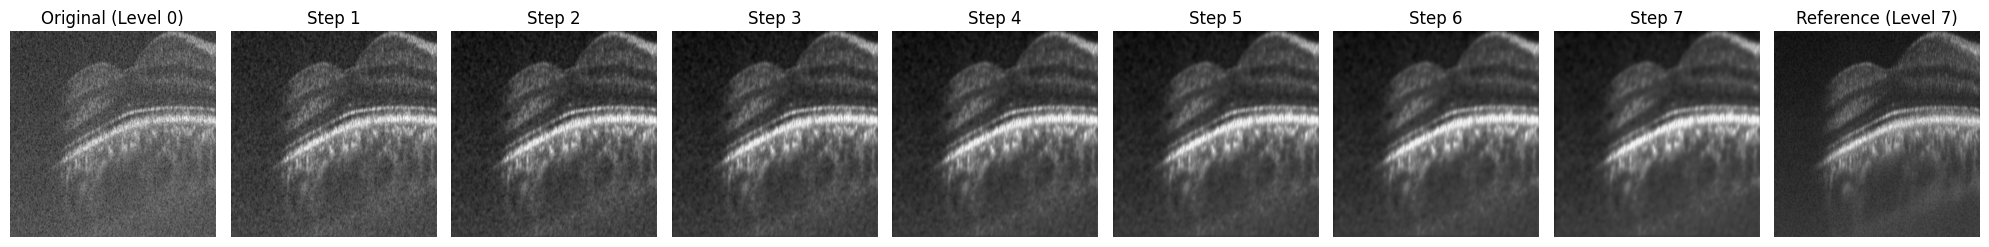

In [45]:
class NoiseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Larger encoder with residual connections
        self.enc1 = nn.Conv2d(1, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 32, 3, padding=1)
        
        # Decoder with same structure
        self.dec1 = nn.Conv2d(32, 64, 3, padding=1)
        self.dec2 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec3 = nn.Conv2d(64, 1, 3, padding=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Encoder with residual connections
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(e1)) + e1  # First residual connection
        e3 = self.relu(self.enc3(e2))
        
        # Decoder with residual connections
        d1 = self.relu(self.dec1(e3))
        d2 = self.relu(self.dec2(d1)) + d1  # Second residual connection
        d3 = self.dec3(d2)
        
        # Final residual connection from input
        return torch.sigmoid(d3 + x)

# Keep the same training loop for now
def train_progressive_denoising(model, sample, feature_masks, num_epochs=100):
    """Train model to learn progressive noise reduction"""
    model = model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Get images from sample
    images = sample[0].squeeze()  # Shape [8, 512, 512]
    
    mse_loss = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Train on each consecutive pair of levels
        for level in range(images.shape[0] - 1):
            current = images[level].unsqueeze(0).unsqueeze(0).to('cuda')
            next_level = images[level + 1].unsqueeze(0).unsqueeze(0).to('cuda')
            
            # Predict next level
            predicted = model(current)
            
            # Calculate loss
            loss = mse_loss(predicted, next_level)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')
    
    return model

def denoise_progressively(model, image, num_steps=7):
    """Apply learned denoising progressively"""
    current = image.clone()
    denoising_steps = []
    
    with torch.no_grad():
        for _ in range(num_steps):
            current = model(current)
            denoising_steps.append(current.clone())
    
    return denoising_steps

# Usage
model = NoiseAutoencoder()

# Train
sample = next(iter(dataloader))
results = tracker.process_sample(sample)
tracking_results = tracker.track_features_to_noisy_level(sample, results)
model = train_progressive_denoising(model, sample, [tracking_results['refined_features']])

# Apply progressive denoising to level 0
level0_image = sample[0][:, 0].squeeze().unsqueeze(0).unsqueeze(0).to('cuda')
denoised_steps = denoise_progressively(model, level0_image)

# Visualize progression
plt.figure(figsize=(20, 5))
num_steps = len(denoised_steps)

# Original
plt.subplot(1, num_steps + 2, 1)
plt.imshow(level0_image[0, 0].cpu(), cmap='gray')
plt.title('Original (Level 0)')
plt.axis('off')

# Show denoising progression
for i, denoised in enumerate(denoised_steps):
    plt.subplot(1, num_steps + 2, i + 2)
    plt.imshow(denoised[0, 0].cpu(), cmap='gray')
    plt.title(f'Step {i+1}')
    plt.axis('off')

# Reference
plt.subplot(1, num_steps + 2, num_steps + 2)
plt.imshow(sample[0][0, -1, 0].cpu(), cmap='gray')
plt.title('Reference (Level 7)')
plt.axis('off')

plt.tight_layout()
plt.show()